In [1]:
import pandas as pd

# Load the dataset from 'commodities.csv'
df = pd.read_csv('commodities.csv')

# Convert the 'SourceCalendarDay' to datetime
df['SourceCalendarDay'] = pd.to_datetime(df['SourceCalendarDay'])

# Take input from the user
market_name = input("Enter Market Name: ")
commodity_name = input("Enter Commodity Name: ")

# Filter dataset based on user input
filtered_data = df[(df['Market Name'] == market_name) & (df['Commodity Name'] == commodity_name)]

# Sort data by date
filtered_data = filtered_data.sort_values(by='SourceCalendarDay')

# Extract modal price and prepare it for LSTM model
prices = filtered_data['Modal price for the commodity'].values
prices = prices.reshape(-1, 1)

print(filtered_data.head())


Enter Market Name:  Raghunathpur
Enter Commodity Name:  Paddy(Dhan)(Common)


    ROWID Country  State LGD Code         State  District LGD Code District  \
0   56811   India              22  Chhattisgarh                321  Purulia   
1   68679   India              22  Chhattisgarh                321  Purulia   
2   91860   India              22  Chhattisgarh                321  Purulia   
3  133475   India              22  Chhattisgarh                321  Purulia   
5  146174   India              22  Chhattisgarh                321  Purulia   

    Market Name       Commodity Name Variety of commodities  \
0  Raghunathpur  Paddy(Dhan)(Common)                   Fine   
1  Raghunathpur  Paddy(Dhan)(Common)                   Fine   
2  Raghunathpur  Paddy(Dhan)(Common)                   Fine   
3  Raghunathpur  Paddy(Dhan)(Common)                   Fine   
5  Raghunathpur  Paddy(Dhan)(Common)                   Fine   

  Grade standard of commodity  ...  Modal price for the commodity  \
0                         FAQ  ...                         1450.0   
1       

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Prepare the training data for LSTM (we'll predict the price based on previous 2 days for simplicity)
def create_dataset(data, time_step=2):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 2  # We'll use the previous 2 days to predict the next price
X, Y = create_dataset(scaled_prices, time_step)

# Reshape X to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"Prepared input shape: {X.shape}")


Prepared input shape: (42, 2, 1)


In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, Y, epochs=20, batch_size=1, verbose=1)


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6186
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0870
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0610
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287  
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420  
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0403
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0482  
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261  
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314   
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209  
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1063
Epoch 13/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0389  
Epoch 14/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352
Epoch 15/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
Predicted Future Price: 1509.8389892578125


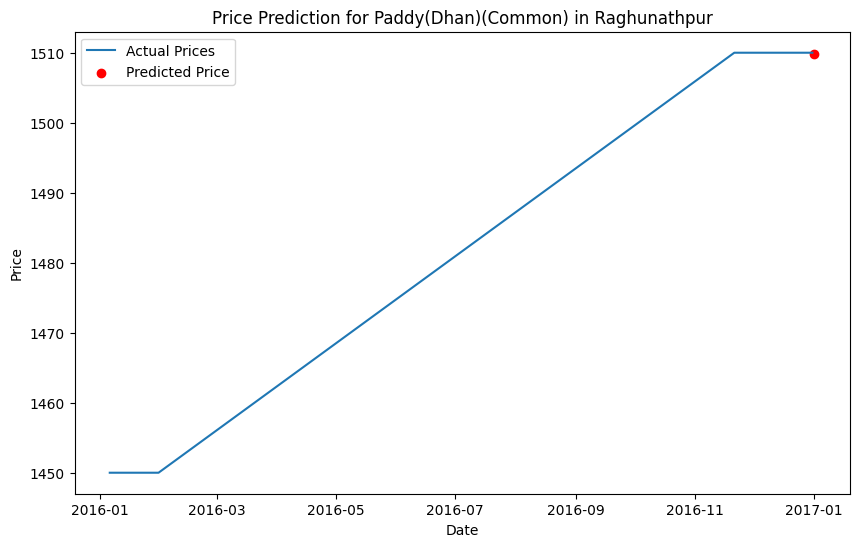

In [4]:
import matplotlib.pyplot as plt

# Predicting future prices (we'll just use the last 2 days for prediction as a simple example)
last_prices = scaled_prices[-time_step:].reshape(1, time_step, 1)
predicted_price_scaled = model.predict(last_prices)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

print(f"Predicted Future Price: {predicted_price[0][0]}")

# Visualize the original and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['SourceCalendarDay'], prices, label="Actual Prices")
plt.scatter(filtered_data['SourceCalendarDay'].iloc[-1] + pd.Timedelta(days=1), predicted_price[0][0], color='red', label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Price Prediction for {commodity_name} in {market_name}")
plt.legend()
plt.show()
